# 3D DeepLabCut Toolbox
https://github.com/DeepLabCut/DeepLabCut

This notebook will highlight the functionality of the newly released 3D project option (as of **2.0.7+**).

We recommend you look through these commands, and then you can easily modify this notebook for your own projects.

**In summary, the new functionality will:**
- allow you to calibrate your cameras using checkerboard images
- compute and fix camera distortions
- convert your 2D DeepLabCut tracking to 3D
- allow for plotting in 3D space

### Create a New 3D Project:

You will run this first function **one** time per project; a project is defined as a given set of cameras and calibration images. You can always analyze new videos within this project.

The function create_new_project_3d creates a new project directory specifically for converting the 2D pose to 3D pose, required subdirectories, and a basic 3D project configuration file. Each project is identified by the name of the project (e.g. Task1), name of the experimenter (e.g. YourName), as well as the date at creation.

Thus, this function requires the user to input the enter the name of the project, the name of the experimenter and number of cameras to be used. Currently, DeepLabCut supports triangulation using 2 cameras, but will expand to more than 2 cameras in a future version.

Optional arguments specify the working directory, i.e. where the project directory will be created. If the optional argument working_directory is unspecified, the project directory is created in the current working directory. Please note that the Full path of the 3D project configuration file will be referenced as ``config_path3d``.

NOTE: Be sure you are inside your DLC anaconda environment!

In [ ]:
import deeplabcut
import numpy as np
import pandas as pd
from deeplabcut.pose_estimation_3d import triangulation, plotting3D
from deeplabcut.utils import auxiliaryfunctions, auxiliaryfunctions_3d, auxfun_multianimal, make_labeled_video
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FFMpegWriter
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.cm as cm
%matplotlib inline



In [3]:
config_path = Path("AcinoSet-Cam12-testDLC-2025-10-31-3d/config.yaml")
print(config_path)

AcinoSet-Cam12-testDLC-2025-10-31-3d\config.yaml


In [2]:
#Setup your project variables:
YourName = 'testDLC'
YourExperimentName = 'AcinoSet-Cam12'

In [12]:
config_path = deeplabcut.create_new_project_3d(YourExperimentName,YourName,num_cameras=2)

Created "C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\camera_matrix"
Created "C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\calibration_images"
Created "C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\undistortion"
Created "C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\corners"
Created "C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\removed_calibration_images"
Generated "C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\config.yaml"

A new project with name AcinoSet-Cam12-testDLC-2025-10-31-3d is created at C:\Users\locha\Documents\Work\3D-DLC-AcinoSet and a configurable file (config.yaml) is stored there. If you have not calibrated the cameras, then use the function 'calibrate_camera' to start calibrating the camera otherwise use the function ``triangulate`` to triangulate

**TIP 1:** you can also pass ``working_directory='Full path of the working directory'`` if you want to place this folder somewhere beside the current directory you are working in.

**TIP 2:** you can also place config_path3d in front of deeplabcut.create_new_project_3d to create a variable that holds the path to the config.yaml file, i.e. ``config_path3d=deeplabcut.create_new_project_3d(...``

In [9]:
#If you're loading an already created project, just set the 3D Project config_path variable:
#import os
#from pathlib import Path
#config_path3d = os.path.join(os.getcwd(),'testing3D-DeepLabCutTeam-2019-06-05-3d/config.yaml')
#print(config_path3d)

## Calibrate your cameras! 

(**CRITICAL!**) You must take images of a checkerboard to calibrate your images. Here are example boards you could print and use (mount them on a flat, hard surface!): https://markhedleyjones.com/projects/calibration-checkerboard-collection. 
- You must save the image pairs as **.jpg** files. 
- They should be named with the camera-# as the prefix, i.e. **camera-1-01.jpg** and **camera-2-01.jpg** for the first pair of images. 
- While taking the images:
     - Keep the orientation of the chessboard same and do not rotate more than 30 degrees. Rotating the chessboard circular will change the origin across the frames and may result in incorrect order of detected corners.

     - Cover several distances, and within each distance, cover all parts of the image view (all corners and center).

     - Use a checkerboard as big as possible, ideally with at least 8x6 squares.

     - Aim for taking at least 70 pair of images as after corner detection, some of the images might need to be discarded due to either incorrect corner detection or incorrect order of detected corners.
     
#### DEMO images:
 
Here, we used a standard set along with this notebook. These images are a part of the Camera Calibration ToolBox for Matlab; specifically example 5. The images can be downloaded at: https://data.caltech.edu/records/20164. After downloading, the calibration images can be found at ../calib_doc/htmls/calib_example.zip


If you wish to run this DEMO notebook, download the files and place inside the **calibration_images** directory. (To note, pairs 1 and 6 are not detected correctly, so please delete these images!). 


When acquiring calibration images from your own setup, it is recommended to take multiple pairs of image (around 50-70 pairs!).

The camera calibration is an **iterative process**, where the user needs to select a set of calibration images where the grid pattern is correctly detected. The function:``deeplabcut.calibrate_cameras(config_path)`` 
extracts the grid pattern from the calibration images and store them under the `corners` directory. The grid pattern could be 8x8 or 5x5 etc. We use a pattern of the 8x6 grid to find the internal corners of the checkerboard.

In some cases, it may happen that the corners are not detected correctly or the order of corners detected in the camera-1 image and camera-2 image is incorrect. We need to remove these pair of images as they will reduce the calibration accuracy.

**NEXT/if not done:** please place your (or demo) images into the **calibration_images** directory. 

### Edit the config.yaml file:
- change the camera names; i.e. if you do ""cam1, cam2"", or "camera-1, camera-2", or "left, right", etc.
- Note, that once this is set, you cannot edit these (they are used for other steps).

In [13]:
deeplabcut.calibrate_cameras(config_path, cbrow=6, cbcol=8, calibrate=False, alpha=0.9)

Corners extracted! You may check for the extracted corners in the directory C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\corners and remove the pair of images where the corners are incorrectly detected. If all the corners are detected correctly with right order, then re-run the same function and use the flag ``calibrate=True``, to calbrate the camera.


NOTE: you need to specify how many rows (``cbrow``) and columns (``cbcol``) your checkerboard has (i.e. the intersection points - see demo images if unclear). Also, first set the variable ``calibrate`` to **False**, so you can remove any faulty images. You need to  visually inspect the output to check for the detected corners and select those pair of images where the corners are correctly detected. 

Once all the set of images are selected (namely, delete from the folder any bad pairs!) where the corners and their orders are detected correctly, then the two cameras can be calibrated using:

**They will look like this (one example frame):**
<p align="center">
<img src="https://images.squarespace-cdn.com/content/v1/57f6d51c9f74566f55ecf271/1559776966423-RATM6ZQT8JXHYAN768F6/ke17ZwdGBToddI8pDm48kKmw982fUOZVIQXHUCR1F55Zw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZUJFbgE-7XRK3dMEBRBhUpw5XnxLBmEFHJGf_0qFdDpmIncOw4kq9OpCHNTYqzGO-E1YJr-Thht9Tdog4YtCwrE/right02_corner.jpg?format=500w" width="30%">
</p> 

In [14]:
deeplabcut.calibrate_cameras(config_path, cbrow=6, cbcol=8, calibrate=True, alpha=0.9)

Saving intrinsic camera calibration matrices for camera-1 as a pickle file in C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\camera_matrix
Mean re-projection error for camera-1 images: 0.345 pixels 
Saving intrinsic camera calibration matrices for camera-2 as a pickle file in C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\camera_matrix
Mean re-projection error for camera-2 images: 0.335 pixels 
Computing stereo calibration for 
Saving the stereo parameters for every pair of cameras as a pickle file in C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\camera_matrix
Camera calibration done! Use the function ``check_undistortion`` to check the check the calibration


## Check for Undistortion:

In order to check how well the stereo calibration is, it is recommended to undistort the calibration images and the corner points using camera matrices and project these undistorted points on the undistorted images to check if they align correctly. This can be done in deeplabcut as:


All images are undistorted and stored in C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\undistortion
Use the function ``triangulate`` to undistort the dataframes and compute the triangulation


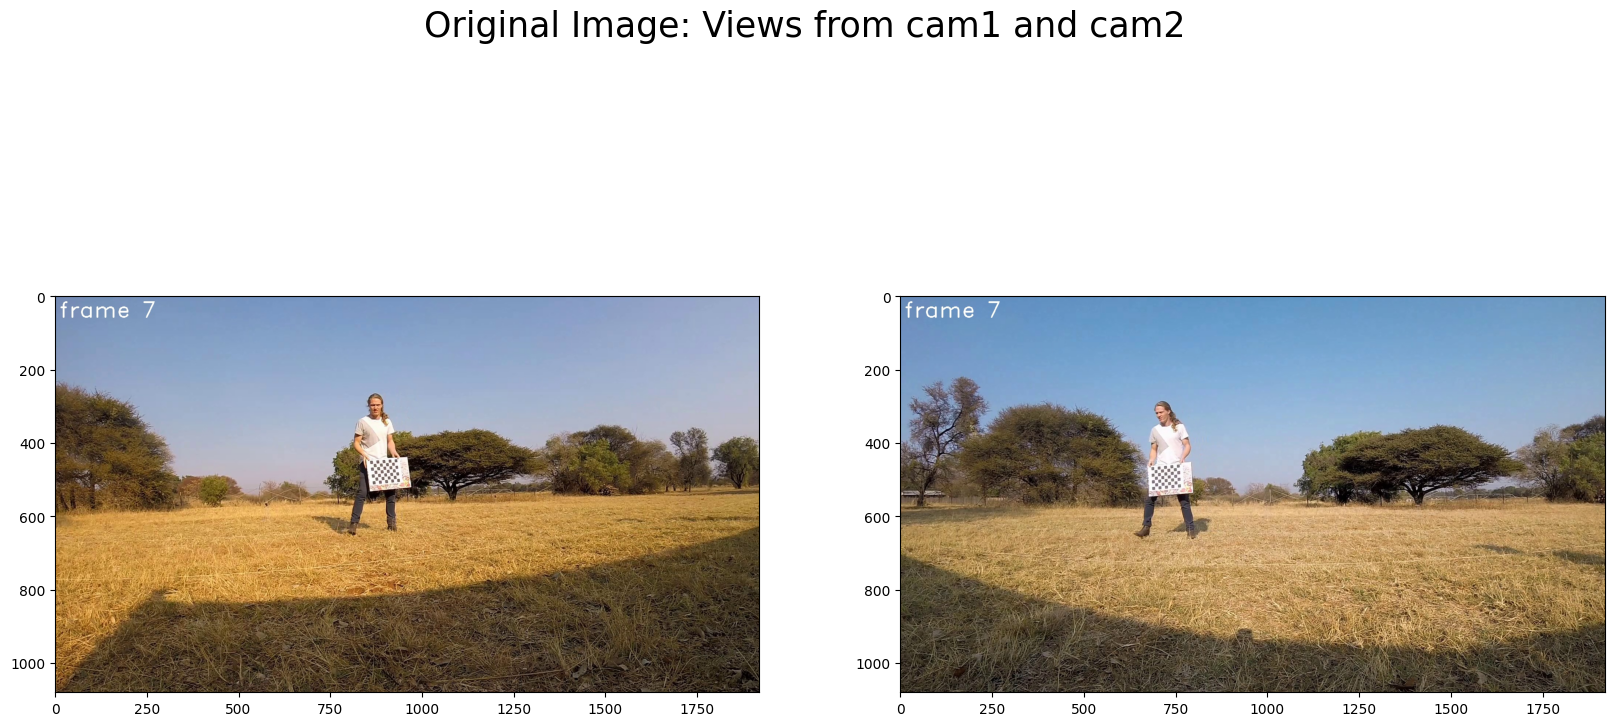

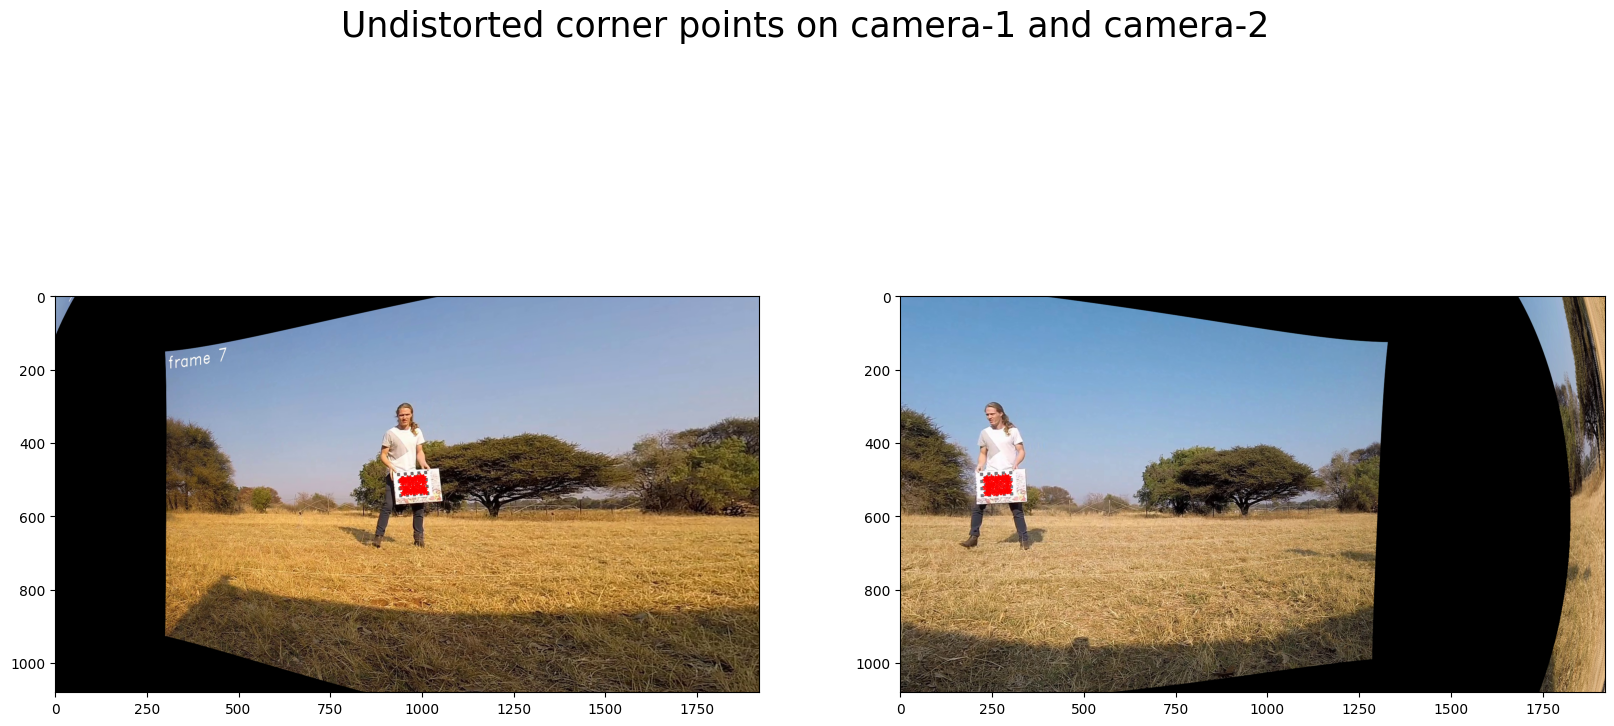

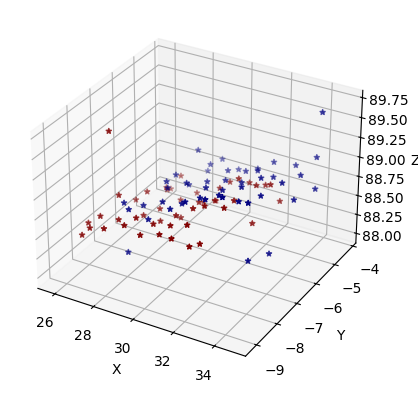

In [ ]:
deeplabcut.check_undistortion(config_path)

Each calibration image is undistorted and saved under the directory ``undistortion``. A plot with a pair of undistorted camera images with its undistorted corner points overlaid is also stored. Please visually inspect this image. All the undistorted corner points from all the calibration images are triangulated and plotted for the user to visualize for any undistortion related errors. If they are not correct, go check and revise the calibration images (then repeat the calirbation and this step)!

## Triangulation --> converting your 2D to 3D! 

If there are no errors in the undistortion, then the pose from the 2 cameras can be triangulated to get the 3D DeepLabCut coordinates!

(**CRITICAL!**) Name the video files in such a way that the file name contains the name of the cameras as specified in the ``config file``. e.g. if the cameras as named as ``camera-1`` and ``camera-2`` (or ``cam-1``, ``cam-2`` etc.) then the video filename must contain this naming, i.e. this could be named as ``rig-1-mouse-day1-camera-1.avi`` and ``rig-1-mouse-day1-camera-2.avi``. Notably, the videos do not need to be the same pixel size, but be sure they are similar in size to the calibration images (and they must be the same cameras used for calibration).

##  (**CRITICAL!**) Edit the config.yaml file: 
You must also edit the **3D project config.yaml** file to denote which DeepLabCut projects have the information for the 2D views. 

 - Of critical importance is that you need to input the **same** body part names as in the config.yaml file of the 2D project.
- You must set the snapshot to use inside the 2D config file (default is -1, namely the last training snapnot of the network). 
- You need to set a "scorer 3D" name; this will point to the project file and be set in future 3D output file names.
- You should define a "skeleton" here as well (note, this is not rigid, it just connects the points in the plotting step). Not every point needs to be "skeletonized", i.e. these points can be a subset of the full body parts list. The other points will just be plotted into the 3D space.



**Next,** pass the ``config_path3d`` and now the ``video_path``, which is the path to the **folder** where all the videos from two cameras are stored. The triangulation can be done in deeplabcut by typing:

In [67]:
video_list = [
    ["AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1-cam1.mp4", 
     "AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1-cam2.mp4"]]
dataname = [
    Path("AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1-cam1DLC_resnet152_CheetahOct14shuffle3_650000.h5"),
    Path("AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1-cam2DLC_resnet152_CheetahOct14shuffle3_650000.h5")
]
cfg_3d = auxiliaryfunctions.read_config(config_path)
cam_names = cfg_3d["camera_names"]
pcutoff = cfg_3d["pcutoff"]
scorer_3d = cfg_3d["scorername_3d"]
cfg_2d = cfg_3d[str("config_file_" + cam_names[0])]
save_as_csv = True
video = video_list[0][0]
destfolder = Path(video).parents[0].as_posix() + "/"
output_file = destfolder + "vid1"
output_filename = output_file + "_" + scorer_3d
string_to_search = scorer_3d + ".h5"

In [8]:
print("Undistorting...")
(
    dataFrame_camera1_undistort,
    dataFrame_camera2_undistort,
    stereomatrix,
    path_stereo_file,
) = triangulation.undistort_points(
    config_path, dataname, str(cam_names[0] + "-" + cam_names[1])
)

Undistorting...


In [9]:
scorer_cam1 = dataFrame_camera1_undistort.columns.get_level_values(0)[0]
scorer_cam2 = dataFrame_camera2_undistort.columns.get_level_values(0)[0]

bodyparts = dataFrame_camera1_undistort.columns.get_level_values(
    "bodyparts"
).unique()

P1 = stereomatrix["P1"]
P2 = stereomatrix["P2"]
F = stereomatrix["F"]

print("Computing the triangulation...")
num_frames = dataFrame_camera1_undistort.shape[0]
### Assign nan to [X,Y] of low likelihood predictions ###
# Convert the data to a np array to easily mask out the low likelihood predictions
data_cam1_tmp = dataFrame_camera1_undistort.to_numpy().reshape(
    (num_frames, -1, 3)
)
data_cam2_tmp = dataFrame_camera2_undistort.to_numpy().reshape(
    (num_frames, -1, 3)
)
# Assign [X,Y] = nan to low likelihood predictions
data_cam1_tmp[data_cam1_tmp[..., 2] < pcutoff, :2] = np.nan
data_cam2_tmp[data_cam2_tmp[..., 2] < pcutoff, :2] = np.nan

# Reshape data back to original shape
data_cam1_tmp = data_cam1_tmp.reshape(num_frames, -1)
data_cam2_tmp = data_cam2_tmp.reshape(num_frames, -1)

# put data back to the dataframes
dataFrame_camera1_undistort[:] = data_cam1_tmp
dataFrame_camera2_undistort[:] = data_cam2_tmp

cfg = auxiliaryfunctions.read_config(cfg_2d)
if cfg.get("multianimalproject"):
    # Check individuals are the same in both views
    individuals_view1 = (
        dataFrame_camera1_undistort.columns.get_level_values("individuals")
        .unique()
        .to_list()
    )
    individuals_view2 = (
        dataFrame_camera2_undistort.columns.get_level_values("individuals")
        .unique()
        .to_list()
    )
    if individuals_view1 != individuals_view2:
        raise ValueError(
            "The individuals do not match between the two DataFrames"
        )

    # Cross-view match individuals
    _, voting = auxiliaryfunctions_3d.cross_view_match_dataframes(
        dataFrame_camera1_undistort, dataFrame_camera2_undistort, F
    )
else:
    # Create a dummy variables for single-animal
    individuals_view1 = ["indie"]
    voting = {0: 0}

# Cleaner variable (since inds view1 == inds view2)
individuals = individuals_view1

# Reshape: (num_framex, num_individuals, num_bodyparts , 2)
all_points_cam1 = dataFrame_camera1_undistort.to_numpy().reshape(
    (num_frames, len(individuals), -1, 3)
)[..., :2]
all_points_cam2 = dataFrame_camera2_undistort.to_numpy().reshape(
    (num_frames, len(individuals), -1, 3)
)[..., :2]

# Triangulate data
triangulate = []
for i, _ in enumerate(individuals):
    # i is individual in view 1
    # voting[i] is the matched individual in view 2

    pts_indv_cam1 = all_points_cam1[:, i].reshape((-1, 2)).T
    pts_indv_cam2 = all_points_cam2[:, voting[i]].reshape((-1, 2)).T

    indv_points_3d = auxiliaryfunctions_3d.triangulatePoints(
        P1, P2, pts_indv_cam1, pts_indv_cam2
    )

    indv_points_3d = indv_points_3d[:3].T.reshape((num_frames, -1, 3))

    triangulate.append(indv_points_3d)

triangulate = np.asanyarray(triangulate)
metadata = {}
metadata["stereo_matrix"] = stereomatrix
metadata["stereo_matrix_file"] = path_stereo_file
metadata["scorer_name"] = {
    cam_names[0]: scorer_cam1,
    cam_names[1]: scorer_cam2,
}

# Create 3D DataFrame column and row indices
cols = [
    [scorer_3d],
    list(auxiliaryfunctions.get_bodyparts(cfg)),
    ["x", "y", "z"],
]
cols_names = ["scorer", "bodyparts", "coords"]
flag_indiv_single = False
if cfg.get("multianimalproject"):
    cols_names.insert(1, "individuals")
    if "single" == individuals[-1]:
        individuals = individuals[:-1]
        columns_unique = pd.MultiIndex.from_product(
            [
                [scorer_3d],
                ["single"],
                auxiliaryfunctions.get_unique_bodyparts(cfg),
                ["x", "y", "z"],
            ],
            names=cols_names,
        )
        flag_indiv_single = True
    cols.insert(1, individuals)
columns = pd.MultiIndex.from_product(cols, names=cols_names)
if flag_indiv_single:
    columns = columns.append(columns_unique)
    individuals.append("single")

inds = range(num_frames)

# Swap num_animals with num_frames axes to ensure well-behaving reshape
triangulate = triangulate.swapaxes(0, 1).reshape((num_frames, -1))

# Fill up 3D dataframe
df_3d = pd.DataFrame(triangulate, columns=columns, index=inds)

df_3d.to_hdf(
    str(output_filename) + ".h5",
    key="df_with_missing",
    mode="w",
    format="table",
)

# Reorder 2D dataframe in view 2 to match order of view 1
if cfg.get("multianimalproject"):
    df_2d_view2 = pd.read_hdf(dataname[1])
    individuals_order = [individuals[i] for i in list(voting.values())]
    df_2d_view2 = auxfun_multianimal.reorder_individuals_in_df(
        df_2d_view2, individuals_order
    )
    df_2d_view2.to_hdf(
        dataname[1],
        key="tracks",
        format="table",
        mode="w",
    )

auxiliaryfunctions_3d.SaveMetadata3d(
    str(output_filename) + "_meta.pickle", metadata
)

if save_as_csv:
    df_3d.to_csv(str(output_filename) + ".csv")

print("Triangulated data for video", video)
print("Results are saved under: ", destfolder)
# have to make the dest folder none so that it can be updated for a new pair of videos
if destfolder == str(Path(video).parents[0]):
    destfolder = None



Computing the triangulation...
Triangulated data for video AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1-cam1.mp4
Results are saved under:  AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/


In [ ]:
# Of course, this does not work on the demo calibration images, 
# but when you are ready for your own dataset, edit and then run the following!

video_path = "AcinoSet_2017_08_29_top_jules_run1_1/dlc"
deeplabcut.triangulate(config_path, video_path, videotype="mp4")

The **triangulated file** is now saved under the same directory where the video files reside (or you passed a destination folder path)! These files can now be used for future analysis. This step can now be run at anytime as you collect new videos, and easily added to your automated analysis pipeline, i.e. such as using``deeplabcut.triangulate(config_path3d, video_path)`` instead of ``deeplabcut.analyze_videos``

## Visualize your 3D DeepLabCut Videos:

In order to visualize the pose in 3D, the user can create a 3D video for certain frames (these are large files, so we advise just looking at a subset of frames). The user can specify the path of the triangulated file and specify the start and end frame indices to create a 3D labeled video. Note that the triangulated_file is the newly created file that ends with yourDLC_3D_scorername.h5. This can be done using:

[['AcinoSet_2017_08_29_top_jules_run1_1\\dlc_pw_triangulated\\vid1_DLC_3D.h5', 'AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated\\vid1-cam1.mp4', 'AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated\\vid1-cam2.mp4']]
Creating 3D video from vid1-cam1.mp4 and vid1-cam2.mp4 using vid1_DLC_3D.h5
Looking for filtered predictions...
No filtered predictions found, the unfiltered predictions will be used instead.


100%|██████████| 143/143 [02:26<00:00,  1.02s/it]


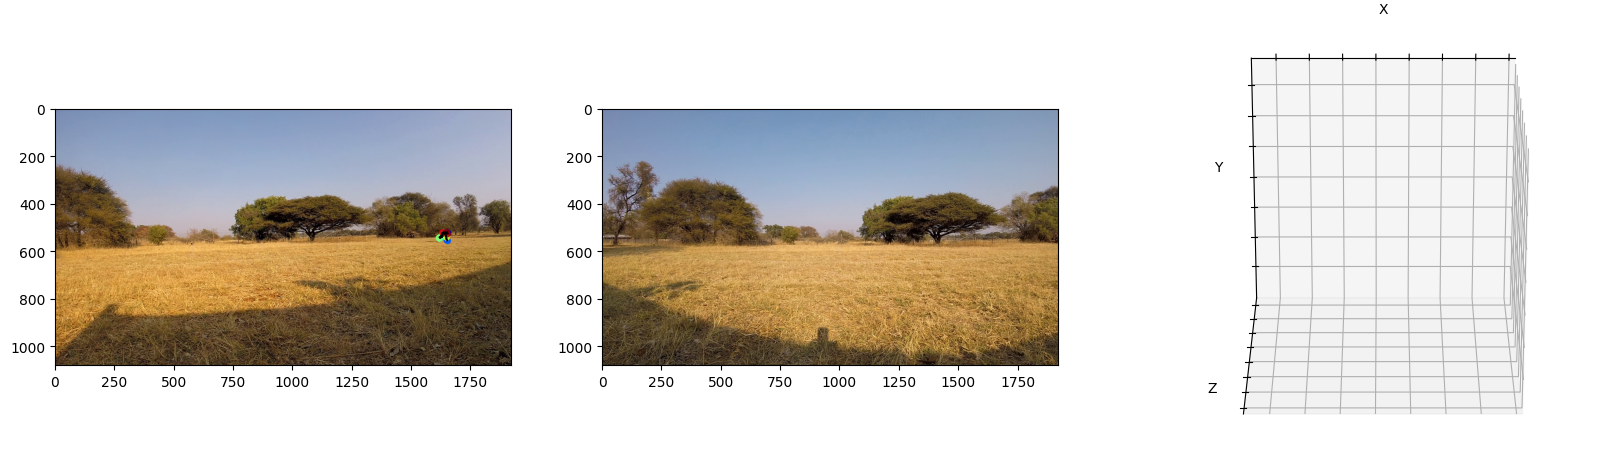

In [155]:
deeplabcut.create_labeled_video_3d(
    config_path,
    ["AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1_DLC_3D.h5"], 
    videofolder="AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated",
    videotype=".mp4",
    view=(113, -270),
    #trailpoints=3,
    fps=90,
)

In [ ]:
# Load 2D h5 files from camera 1 and camera 2
df_cam1 = pd.read_hdf("AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1-cam1DLC_resnet152_CheetahOct14shuffle3_650000.h5")
df_cam2 = pd.read_hdf("AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1-cam2DLC_resnet152_CheetahOct14shuffle3_650000.h5")

In [71]:
df_cam1

scorer    DLC_resnet152_CheetahOct14shuffle3_650000                         \
bodyparts                                     r_eye                          
coords                                            x           y likelihood   
0                                          1.320545  575.134949   0.003989   
1                                          3.145102  567.322937   0.978662   
2                                         16.667479  570.206299   0.997235   
3                                         29.121449  571.631104   0.995681   
4                                         42.246761  569.827637   0.998857   
..                                              ...         ...        ...   
138                                     1637.484375  518.413940   0.739757   
139                                     1642.702637  518.864624   0.904420   
140                                     1645.825073  519.903625   0.914065   
141                                     1647.904297  519.177490   0.936964   
142                                     1650.282349  521.070312   0.731850   

scorer                                                                  \
bodyparts        l_eye                          r_shoulder               
coords               x           y likelihood            x           y   
0             3.710525  575.319885   0.010084    -0.459520  608.290894   
1            13.304768  566.960388   0.991337     1.283590  589.078369   
2            27.174625  569.683044   0.968440     3.153366  579.773682   
3            37.823574  571.096375   0.868627     4.410783  566.930969   
4            50.276134  569.233398   0.947352     6.672134  567.533569   
..                 ...         ...        ...          ...         ...   
138        1640.378174  518.918762   0.703710  1630.964233  528.757202   
139        1645.804932  519.489807   0.781740  1638.973389  527.543640   
140        1650.126587  519.520020   0.790760  1642.062500  528.903870   
141        1653.435791  519.646606   0.944835  1641.555176  528.996338   
142        1654.222656  521.321228   0.736470  1644.745361  527.305115   

scorer                             ...                                      \
bodyparts            r_front_knee  ...       lure    tail_base               
coords    likelihood            x  ... likelihood            x           y   
0           0.003331    -1.687819  ...   0.708848     0.590458  589.097534   
1           0.074197     3.262968  ...   0.338153     1.706024  572.952942   
2           0.337151     4.609295  ...   0.841124     4.835115  556.900696   
3           0.378229     2.982057  ...   0.872657    19.775881  557.898987   
4           0.777540     5.184050  ...   0.795593    21.512220  557.851685   
..               ...          ...  ...        ...          ...         ...   
138         0.956008  1633.388184  ...   0.004175  1619.315308  518.617859   
139         0.974747  1640.245239  ...   0.005616  1622.490601  519.486938   
140         0.944859  1643.599854  ...   0.007680  1621.635620  523.420471   
141         0.946925  1646.146606  ...   0.003236  1626.365479  518.597107   
142         0.938297  1646.802002  ...   0.004722  1631.900391  520.577515   

scorer                                                                 \
bodyparts                    nose                           neck_base   
coords    likelihood            x           y likelihood            x   
0           0.001458     7.418496  600.860657   0.048414   574.271545   
1           0.005383    10.109616  576.877869   0.994511     4.334373   
2           0.004404    24.233000  579.186707   0.997758     5.083476   
3           0.008820    37.286682  579.984375   0.996008    16.237877   
4           0.001985    48.362633  579.830383   0.999471    23.839785   
..               ...          ...         ...        ...          ...   
138         0.701654  1638.137329  524.603210   0.862057  1635.251099   
139         0.579543  1643.740356  523.376099  

In [ ]:
# Load 3D h5 file
df_3d = pd.read_hdf("AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1_DLC_3D.h5")
df_3d

scorer        DLC_3D                                                         \
bodyparts      r_eye                            l_eye                         
coords             x         y           z          x         y           z   
0                NaN       NaN         NaN        NaN       NaN         NaN   
1         -45.745763 -0.834393  102.080299 -45.187754 -0.830579  102.277005   
2         -44.792870 -0.875693  101.861431 -44.078789 -0.678114  101.754836   
3         -44.277247 -0.675260  102.497548 -43.630121 -0.654039  102.288197   
4         -43.498616 -0.576664  102.648615 -43.028236 -0.507497  102.760656   
..               ...       ...         ...        ...       ...         ...   
138              NaN       NaN         NaN        NaN       NaN         NaN   
139              NaN       NaN         NaN        NaN       NaN         NaN   
140              NaN       NaN         NaN        NaN       NaN         NaN   
141              NaN       NaN         NaN        NaN       NaN         NaN   
142              NaN       NaN         NaN        NaN       NaN         NaN   

scorer                                                   ...             \
bodyparts r_shoulder                       r_front_knee  ...       lure   
coords             x         y           z            x  ...          z   
0                NaN       NaN         NaN          NaN  ...  63.114860   
1                NaN       NaN         NaN          NaN  ...        NaN   
2                NaN       NaN         NaN   -44.270067  ...  61.058503   
3                NaN       NaN         NaN   -45.646209  ...  60.968845   
4         -45.559128 -1.010179  102.162918   -45.588156  ...  60.438558   
..               ...       ...         ...          ...  ...        ...   
138              NaN       NaN         NaN          NaN  ...        NaN   
139              NaN       NaN         NaN          NaN  ...        NaN   
140              NaN       NaN         NaN          NaN  ...        NaN   
141              NaN       NaN         NaN          NaN  ...        NaN   
142              NaN       NaN         NaN          NaN  ...        NaN   

scorer                                                                   \
bodyparts tail_base               nose                        neck_base   
coords            x   y   z          x         y           z          x   
0               NaN NaN NaN        NaN       NaN         NaN        NaN   
1               NaN NaN NaN -45.433849  0.184604  102.363467        NaN   
2               NaN NaN NaN -44.209467  0.022909  101.616243        NaN   
3               NaN NaN NaN -43.734521  0.263965  102.443683 -44.864744   
4               NaN NaN NaN -43.096192  0.448717  102.616446 -44.482072   
..              ...  ..  ..        ...       ...         ...        ...   
138             NaN NaN NaN        NaN       NaN         NaN        NaN   
139             NaN NaN NaN        NaN       NaN         NaN        NaN   
140             NaN NaN NaN        NaN       NaN         NaN        NaN   
141             NaN NaN NaN        NaN       NaN         NaN        NaN   
142             NaN NaN NaN        NaN       NaN         NaN        NaN   

scorer                           
bodyparts                        
coords            y           z  
0               NaN         NaN  
1               NaN         NaN  
2               NaN         NaN  
3         -2.140722  101.970075  
4         -2.249691  102.203901  
..              ...         ...  
138             NaN         NaN  
139             NaN         NaN  
140             NaN         NaN  
141             NaN         NaN  
142             NaN         NaN  

[143 rows x 75 columns]

In [88]:
# Load stereo params
metadata_3d = auxiliaryfunctions_3d.LoadMetadata3d("AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1_DLC_3D_meta.pickle")

C:\Users\locha\AppData\Local\Temp\ipykernel_316164\323599783.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(bodyparts))


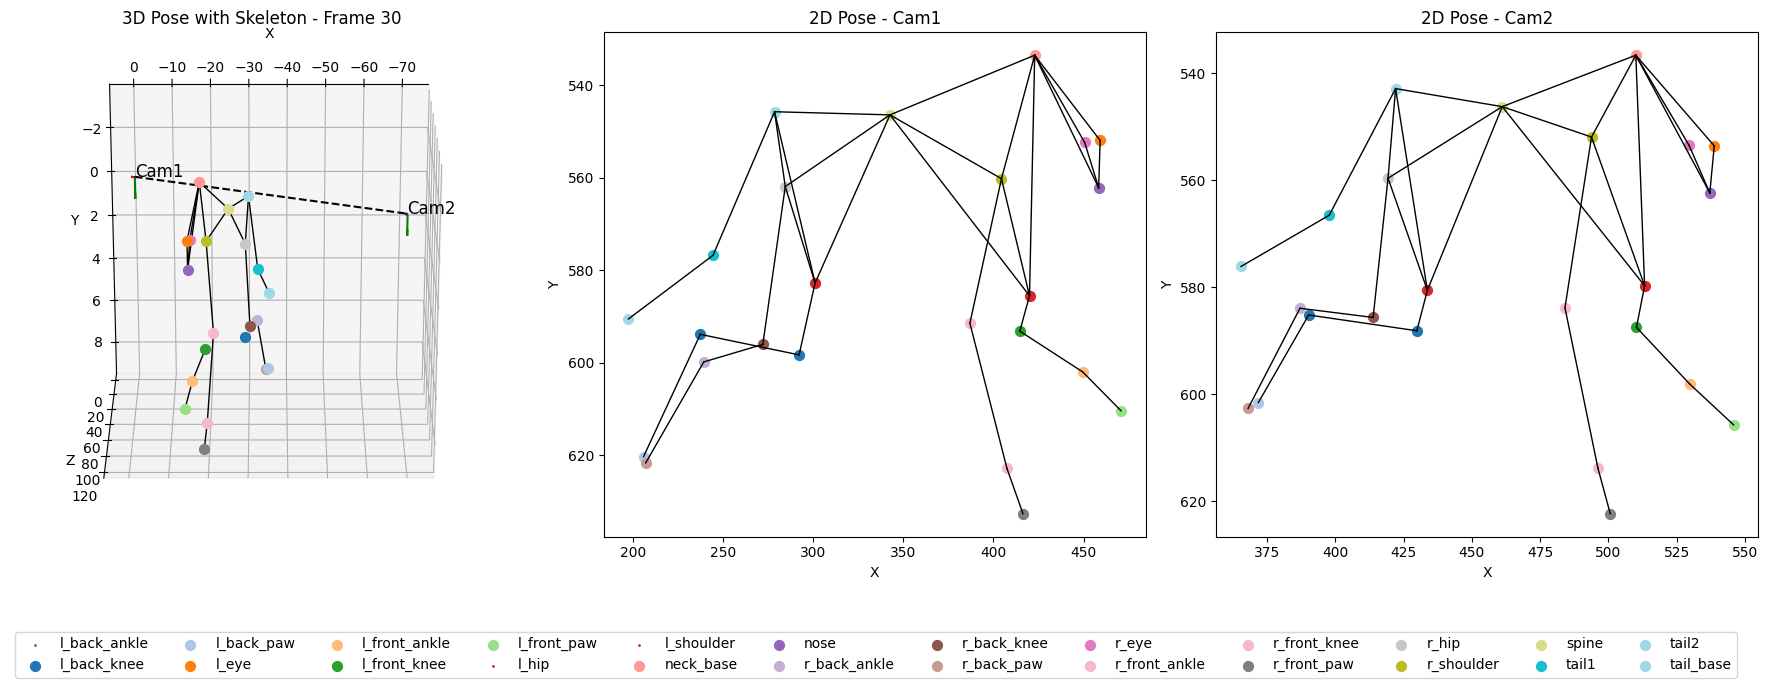

In [ ]:
frame_num = 30
frame = df_3d.iloc[frame_num]
frame_cam1 = df_cam1.iloc[frame_num]
frame_cam2 = df_cam2.iloc[frame_num]

# Get bodyparts from the MultiIndex
bodyparts = df_3d.columns.levels[1]
bodyparts = [bp for bp in bodyparts if "lure" not in bp]
scorer_name_3d = df_3d.columns.levels[0][0]
scorer_name_2d = df_cam1.columns.levels[0][0]
# Build coordinate lookup
coords_3d = {
    bp: (
        frame[scorer_name_3d, bp, 'x'],
        frame[scorer_name_3d, bp, 'y'],
        frame[scorer_name_3d, bp, 'z']
    )
    for bp in bodyparts
}
# Assign unique colors
cmap = cm.get_cmap('tab20', len(bodyparts))
colors = [cmap(i) for i in range(len(bodyparts))]
color_map = dict(zip(bodyparts, colors))

fig = plt.figure(figsize=(18, 6))

# Subplot 1: 3D pose
ax1 = fig.add_subplot(131, projection='3d')
# Plot keypoints
for bp in bodyparts:
    x, y, z = coords_3d[bp]
    ax1.scatter(x, y, z, color=color_map[bp], label=bp, s=50)
# Plot skeleton lines
for bp1, bp2 in cfg_3d["skeleton"]:
    if bp1 in coords_3d and bp2 in coords_3d:
        x_vals = [coords_3d[bp1][0], coords_3d[bp2][0]]
        y_vals = [coords_3d[bp1][1], coords_3d[bp2][1]]
        z_vals = [coords_3d[bp1][2], coords_3d[bp2][2]]
        ax1.plot(x_vals, y_vals, z_vals, color='black', linewidth=1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f"3D Pose with Skeleton - Frame {frame_num}")
ax1.view_init(elev=113, azim=-270)
#ax1.invert_zaxis()
#ax1.invert_xaxis()

# Camera 1 at origin
origin1 = np.array([0, 0, 0])
axes1 = np.eye(3)
# Camera 2 at translated position
origin2 = metadata_3d["stereo_matrix"]['T'].reshape(3)
axes2 = metadata_3d["stereo_matrix"]['R']
for i, color in zip(range(3), ['r', 'g', 'b']):
    ax1.quiver(*origin1, *axes1[:, i], color=color)
    ax1.quiver(*origin2, *axes2[:, i], color=color)
# Label cameras
ax1.text(*origin1, 'Cam1', fontsize=12)
ax1.text(*origin2, 'Cam2', fontsize=12)
# Draw baseline
ax1.plot([origin1[0], origin2[0]], [origin1[1], origin2[1]], [origin1[2], origin2[2]], 'k--')

# Subplot 2: 2D pose cam1
ax2 = fig.add_subplot(132)
for bp in bodyparts:
    x = frame_cam1[scorer_name_2d, bp, 'x']
    y = frame_cam1[scorer_name_2d, bp, 'y']
    ax2.scatter(x, y, color=color_map[bp], label=bp, s=50)
ax2.set_title('2D Pose - Cam1')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.invert_yaxis()

# Subplot 3: 2D pose cam2
ax3 = fig.add_subplot(133)
for bp in bodyparts:
    x = frame_cam2[scorer_name_2d, bp, 'x']
    y = frame_cam2[scorer_name_2d, bp, 'y']
    ax3.scatter(x, y, color=color_map[bp], label=bp, s=50)
ax3.set_title('2D Pose - Cam2')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.invert_yaxis()

# Plot skeleton lines
for bp1, bp2 in cfg_3d["skeleton"]:
    if bp1 in bodyparts and bp2 in bodyparts:
        x_vals = [
            [frame_cam1[scorer_name_2d, bp1, 'x'],
            frame_cam1[scorer_name_2d, bp2, 'x']],
            [frame_cam2[scorer_name_2d, bp1, 'x'],
            frame_cam2[scorer_name_2d, bp2, 'x']]
        ]
        y_vals = [
            [frame_cam1[scorer_name_2d, bp1, 'y'],
            frame_cam1[scorer_name_2d, bp2, 'y']],
            [frame_cam2[scorer_name_2d, bp1, 'y'],
            frame_cam2[scorer_name_2d, bp2, 'y']]
        ]
        ax2.plot(x_vals[0], y_vals[0], color='black', linewidth=1)
        ax3.plot(x_vals[1], y_vals[1], color='black', linewidth=1)

# Show legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(bodyparts)//2, bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.show()


In [121]:
frame[scorer_name_3d, "r_eye", :], frame[scorer_name_3d, "l_eye", :]

(coords
 x    -15.941981
 y     -0.663638
 z    116.979736
 Name: 30, dtype: float64,
 coords
 x    -15.254098
 y     -0.647313
 z    118.051218
 Name: 30, dtype: float64)

In [124]:
frame[scorer_name_3d, "tail2", :], frame[scorer_name_3d, "nose", :]

(coords
 x    -35.291517
 y      1.880071
 z    109.112236
 Name: 30, dtype: float64,
 coords
 x    -15.313867
 y      0.597982
 z    117.776583
 Name: 30, dtype: float64)

In [122]:
frame[scorer_name_3d, "r_back_knee", :], frame[scorer_name_3d, "l_back_knee", :]

(coords
 x    -30.533489
 y      3.234955
 z    112.194038
 Name: 30, dtype: float64,
 coords
 x    -29.313056
 y      3.675816
 z    113.682436
 Name: 30, dtype: float64)